# Overview

The task at hand is classification of wine quality

We will use 3 different approaches:

- A standard neural network (feed fordward nn)
- A bayesian neural network that will take into account epistemic (model) uncertainty on the predicted labels
- A probabilistic neural network that will take into account both aleatoric (data) and epistemic (model) uncertainty on the predicted labels

## Workflow

1. [Data Inspection](#inspection) 
    - Loading
    - Inspection
    - Preprocessing
2. [Modeling](#model-definition)
    - Standard Neural Network
    - Bayesian Neural Network
    - Probabilistic Neural Network
3. [Prediction](#prediction)

In [62]:
# Software install (as required)
#!pip install -r ../requirements.txt

In [63]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Inspection <a name="inspection"></a>

In [64]:
def load_data(dataset_name="wine_quality",buffer_size=4998,split="train",batch_size=256,train_size=3000):
    # Data Load
    ds , ds_info = tfds.load(name=dataset_name, as_supervised=True, split=split,with_info=True)
    ds.map(lambda x, y: (x, tf.cast(y, tf.float32))).prefetch(buffer_size=buffer_size).cache()
    return ds, ds_info

def split_data(dataset,batch_size=256,train_size=3000):
    # Data Split
    # Train : we shuffle with a buffer the same size as the dataset.
    ds_train = (
        dataset
        .take(train_size)
        .shuffle(buffer_size=train_size)
        .batch(batch_size)
    )
    # Test : no shuffle
    ds_test = (
        dataset
        .skip(train_size)
        .batch(batch_size)
    )

    return ds_train,ds_test


In [65]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)

# load data
ds ,ds_info = load_data(
    dataset_name="wine_quality",
    buffer_size=dataset_size, # We prefetch with a buffer the same size as the dataset because th dataset is very small and fits into memory.
    ) 
    
# split data
ds_train,ds_test = split_data(
    dataset=ds,
    batch_size=batch_size,
    train_size=train_size)

In [66]:
# Basic Info
feature_names=list(ds_info.features['features'].keys())
print("Total examples: %d" %(len(ds_train)+len(ds_test)))
print("Train set size: %d" %len(ds_train)) 
print("Test set size : %d" %len(ds_test))   
print("Feature names : %s" %feature_names)

Total examples: 20
Train set size: 17
Test set size : 3
Feature names : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [67]:
# show a few examples from the train dataset
tfds.as_dataframe(ds_train.unbatch().take(10), ds_info)

2023-05-25 14:50:05.286144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-25 14:50:05.286792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 14:50:05.488333: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity,quality
0,9.600000381469727,0.07100000232458115,0.30000001192092896,0.9923999905586243,5.5,27.0,3.140000104904175,2.5,0.5099999904632568,128.0,0.33500000834465027,6
1,11.399999618530273,0.04100000113248825,0.33000001311302185,0.9904800057411194,7.0,20.0,3.2100000381469727,0.8999999761581421,0.5,117.0,0.28999999165534973,5
2,9.899999618530273,0.04500000178813934,0.3400000035762787,0.993399977684021,7.400000095367432,73.5,3.180000066757202,2.299999952316284,0.6100000143051147,214.0,0.1550000011920929,7
3,8.699999809265137,0.0560000017285347,0.30000001192092896,0.9982500076293945,7.400000095367432,33.0,2.9000000953674316,13.699999809265137,0.4399999976158142,168.0,0.1599999964237213,7
4,12.699999809265137,0.029999999329447746,0.25999999046325684,0.9904500246047974,6.699999809265137,15.0,3.1500000953674316,5.400000095367432,0.3799999952316284,94.0,0.23999999463558197,6
5,11.699999809265137,0.029999999329447746,0.30000001192092896,0.9926999807357788,6.300000190734863,49.0,3.5299999713897705,3.200000047683716,0.7900000214576721,164.0,0.4099999964237213,7
6,9.399999618530273,0.0430000014603138,0.18000000715255737,0.9956600069999695,6.699999809265137,57.0,3.1700000762939453,7.699999809265137,0.4399999976158142,200.0,0.3100000023841858,6
7,12.699999809265137,0.02500000037252903,0.3400000035762787,0.9896100163459778,6.0,23.0,3.359999895095825,1.2999999523162842,0.3700000047683716,111.0,0.23000000417232513,6
8,10.800000190734863,0.03999999910593033,0.3700000047683716,0.9919999837875366,7.900000095367432,16.0,3.180000066757202,1.2000000476837158,0.6299999952316284,75.0,0.18000000715255737,5
9,10.600000381469727,0.041999999433755875,0.4000000059604645,0.9915000200271606,7.699999809265137,9.0,2.890000104904175,1.100000023841858,0.5,60.0,0.25999999046325684,5


In [68]:
# Class balance check : is the dataset imbalanced?
#fig, ax = plt.subplots(1, 1, figsize=(10,6))
#labels, counts = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), np.int32),  return_counts=True)
#ax.set_xlabel('Counts')
#ax.set_title("Counts by type");
#sns.barplot(x=counts, y=[class_names[l] for l in labels], label="Total")
#ax.grid(True,ls='--')
#sns.despine(left=True, bottom=True)

In [69]:
# IF needed
def prepare_for_training(ds, cache=True, batch_size=1, shuffle_buffer_size=1000):
  ds = ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
  ds = ds.prefetch(buffer_size=4898)
  ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model is training.
  return ds

In [70]:
# Function to create model inputs
def create_model_inputs(feature_names=[]):
    inputs = {}
    for name in feature_names:
        print('creating model input layer for : %s' %name)
        inputs[name] = layers.Input(
            name=name.replace(" ","_"), shape=(1,), dtype=tf.float32
        )
    return inputs

# Function to define a prior model in the context of Bayesian inference
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Function to define a posterior model in the context of Bayesian inference
# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


# Create Standard Neural Network
def base_neural_network(hidden_units=None,inputs=None,feature_names=[]):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs,name='StandardNeuralNet')
    return model

# Create Bayesian Neural Network : to capture epistemic (model) uncertainty due to limited training data
def bayesian_neural_network(train_size=1000,hidden_units=None,inputs=None,feature_names=[],activation='sigmoid'):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=activation,
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs,name='BayesNeuralNet')
    return model

# Create Probabilistics Neural Network : to capture epistemic (model) uncertainty due to limited training data and aleatoric (data) uncertainty due to randomness
def probabilistic_neural_network(train_size=1000,hidden_units=None,inputs=None,feature_names=[],activation='sigmoid'):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=activation,
        )(features)

    # Create a probabilistic output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)
    model = keras.Model(inputs=inputs, outputs=outputs,name='ProbabilisticNeuralNet')
    return model

# Since the output of the probabilistic neural network is a distribution, rather than a point estimate, 
# we use the negative loglikelihood as our loss function to compute how likely to see the true data (targets) 
# from the estimated distribution produced by the model.
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

# Function to train and evaluate a model (experiment run)
def run_experiment(model, loss, train_dataset, test_dataset, num_epochs, learning_rate):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Model training started ...")
    history = model.fit(
        train_dataset, 
        epochs=num_epochs, 
        validation_data=test_dataset)
    
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")
    
    return history

# Function to plot the training history
def plot_training(history,namealpha=1.,learning_rate=0.01,figsize=(8,6)):
    # PLot training history for loss
    title= history.model.name + ' learning rate :' + str(learning_rate)
    f,ax=plt.subplots(1,1,figsize=figsize)
    ax.plot(history.history['loss'],label='Train Loss',alpha=0.5)
    ax.plot(history.history['val_loss'],label='Val Loss',alpha=0.5)
    plt.title(title)
    plt.ylabel('loss',fontsize=10)
    plt.xlabel('epoch',fontsize=10)
    plt.legend(loc='upper right',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

In [71]:
arch_type = 'nn'
model_filename = "wine_quality_classification_"+arch_type
model_path = os.path.join("../models", model_filename + ".h5")
if not os.path.exists("../models"):
    os.makedirs(model_path)

### Train Base Neural Network <a name="model training"></a>

In [72]:
hidden_units = [8, 8]
learning_rate = 0.001
num_epochs = 100
standard = base_neural_network(hidden_units=hidden_units,feature_names=feature_names)
history = run_experiment(
    model=standard, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)


creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/100


2023-05-25 14:50:18.492130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 14:50:18.492764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


 1/17 [>.............................] - ETA: 21s - loss: 43.9920 - root_mean_squared_error: 6.6326

2023-05-25 14:50:19.852268: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-05-25 14:50:19.888714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 14:50:19.889452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

17/17 [==============================] - 2s 24ms/step - loss: 42.6379 - root_mean_squared_error: 6.5298 - val_loss: 41.7085 - val_root_mean_squared_error: 6.4582
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 40.2615 - root_mean_squared_error: 6.3452 - val_loss: 40.0329 - val_root_mean_squared_error: 6.3272
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 38.2802 - root_mean_squared_error: 6.1871 - val_loss: 38.2354 - val_root_mean_squared_error: 6.1835
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 36.3896 - root_mean_squared_error: 6.0324 - val_loss: 36.4467 - val_root_mean_squared_error: 6.0371
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 34.5621 - root_mean_squared_error: 5.8790 - val_loss: 34.6793 - val_root_mean_squared_error: 5.8889
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 32.7949 - root_mean_squared_error: 5.7267 - val_loss: 32.9575 - val_root_

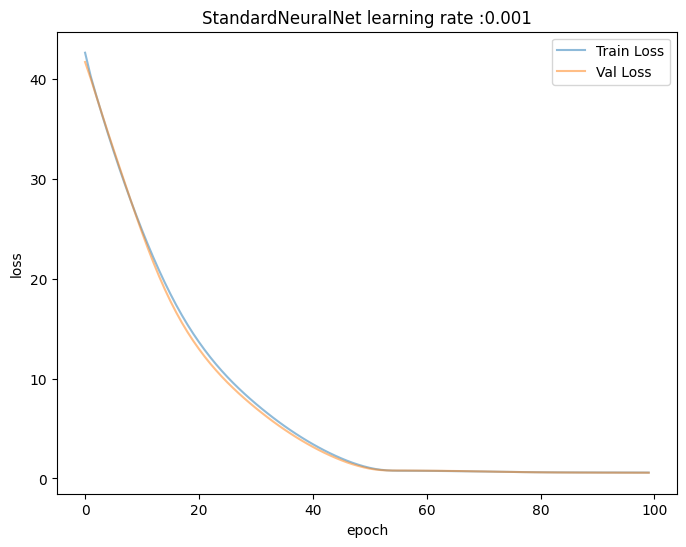

In [73]:
plot_training(history=history,learning_rate=learning_rate)

We take a sample from the test set use the model to obtain predictions for them. Note that since the baseline model is deterministic, we get a single a point estimate prediction for each test example, with no information about the uncertainty of the model nor the prediction.

### Make some predictions

In [74]:

sample = 10
examples, targets = list(ds_test.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = standard(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

Predicted: 6.2 - Actual: 7
Predicted: 6.6 - Actual: 6
Predicted: 5.5 - Actual: 6
Predicted: 6.0 - Actual: 6
Predicted: 6.5 - Actual: 6
Predicted: 6.4 - Actual: 7
Predicted: 6.3 - Actual: 5
Predicted: 6.1 - Actual: 7
Predicted: 6.1 - Actual: 6
Predicted: 6.2 - Actual: 5


2023-05-25 14:50:36.175962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 14:50:36.176614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


### Train Bayesian Neural Network on small sample

In [75]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = ds_train.unbatch().take(train_sample_size).batch(batch_size)

# build
bayesian = bayesian_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=train_sample_size)
# train
history = run_experiment(
    model=bayesian, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=small_train_dataset, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)



creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/500


2023-05-25 14:50:40.134081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 14:50:40.134781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 2s 136ms/step - loss: 33.4405 - root_mean_squared_error: 5.7815 - val_loss: 34.1298 - val_root_mean_squared_error: 5.8407
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 32.6968 - root_mean_squared_error: 5.7168 - val_loss: 31.3624 - val_root_mean_squared_error: 5.5993
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 29.6701 - root_mean_squared_error: 5.4456 - val_loss: 27.9468 - val_root_mean_squared_error: 5.2848
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 29.9728 - root_mean_squared_error: 5.4732 - val_loss: 35.5963 - val_root_mean_squared_error: 5.9649
Epoch 5/500
5/5 [==============================] - 0s 16ms/step - loss: 30.8490 - root_mean_squared_error: 5.5527 - val_loss: 28.8138 - val_root_mean_squared_error: 5.3666
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 31.2736 - root_mean_squared_error: 5.5909 - val_loss: 31.6291 - val_root_mean_s

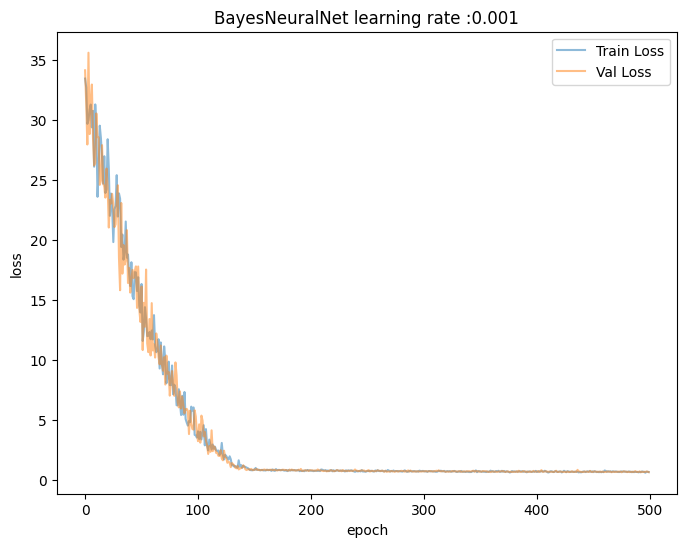

In [76]:
plot_training(history=history,learning_rate=learning_rate)

In [77]:
from statistics import NormalDist

def compute_predictions(model, input=None, iterations=100 , n_samples=10):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(input).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_std = np.std(predicted, axis=1).tolist()
    #prediction_min = np.min(predicted, axis=1).tolist()
    #prediction_max = np.max(predicted, axis=1).tolist()
    #prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(n_samples):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"Predictions  std: {round(prediction_std[idx], 2)}, "
            f"Actual: {targets[idx]}"
        )

    return predicted

def display_predictions(predictions=[], target_values=[], n_samples=10,n_bins=10,figsize=(15,6),n_rows=2,n_cols=5):
    f,axs=plt.subplots(n_rows,n_cols,figsize=figsize)
    k=0
    for i in range(n_rows):
        for j in range(n_cols):
            data=list(predictions[k])
            # normal distribution from the data
            norm = NormalDist.from_samples(data)
            mu = norm.mean
            sigma = norm.stdev
            # plot the predictions
            axs[i][j].hist(data, n_bins, density=True, alpha=0.5,label='Predictions')
            # add the fitted normal distribution line
            x = np.linspace(min(data),max(data),50)
            pdf = [norm.pdf(i) for i in x]
            axs[i][j].plot(x, pdf, 'b', linewidth=1)
            title='Predictions'
            axs[i][j].set_title(title,fontsize=8)
            # add the true target value
            axs[i][j].axvline(x=target_values[k],color='red',lw=2,label='True value')
            axs[i][j].legend(loc='upper right',fontsize=8)
            k+=1

Predictions mean: 6.19, Predictions  std: 0.14, Actual: 7
Predictions mean: 6.33, Predictions  std: 0.14, Actual: 6
Predictions mean: 5.66, Predictions  std: 0.25, Actual: 6
Predictions mean: 6.12, Predictions  std: 0.17, Actual: 6
Predictions mean: 6.37, Predictions  std: 0.1, Actual: 6
Predictions mean: 6.27, Predictions  std: 0.12, Actual: 7
Predictions mean: 6.21, Predictions  std: 0.14, Actual: 5
Predictions mean: 6.12, Predictions  std: 0.16, Actual: 7
Predictions mean: 6.27, Predictions  std: 0.14, Actual: 6
Predictions mean: 6.25, Predictions  std: 0.14, Actual: 5


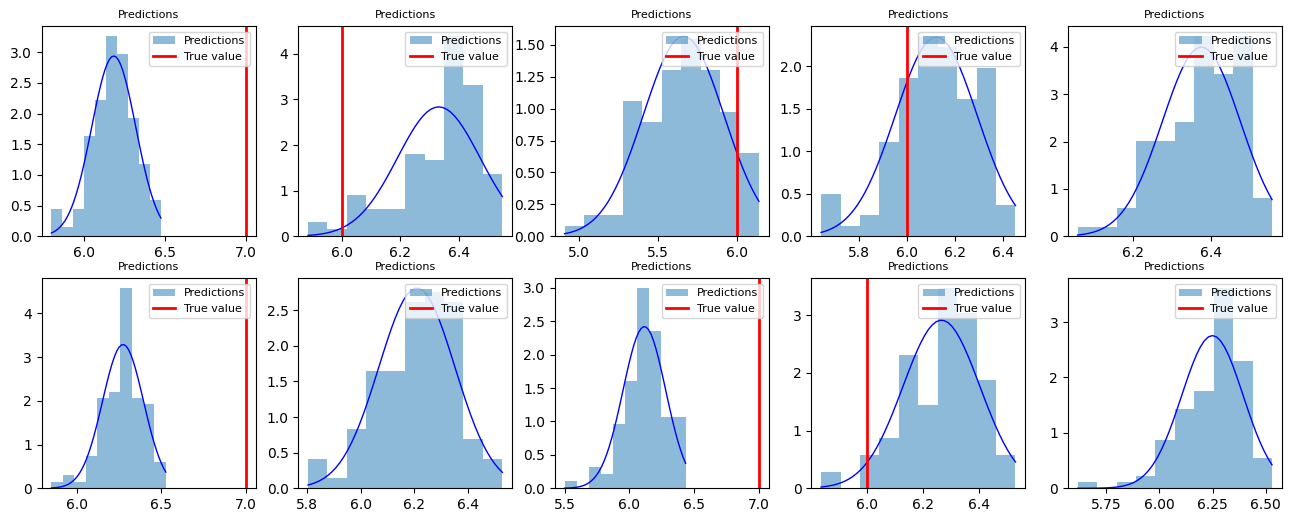

In [78]:
predictions=compute_predictions(
    model=bayesian,
    input=examples,
    )

display_predictions(
    predictions=predictions,
    target_values=targets,
    figsize=(16,6))

### Train Bayesian Neural Network on Full sample

In [79]:
# build
bayes_nn_model_full = bayesian_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=train_size)
# train
history = run_experiment(
    model=bayes_nn_model_full, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/500
17/17 [==============================] - 2s 33ms/step - loss: 50.4010 - root_mean_squared_error: 7.0991 - val_loss: 48.7123 - val_root_mean_squared_error: 6.9790
Epoch 2/500
17/17 [==============================] - 0s 5ms/step - loss: 46.7755 - root_mean_squared_error: 6.8389 - val_loss: 38.8628 - val_root_mean_squared_error: 6.2337
Epoch 3/500
17/17 [==============================] - 0s 5ms/step - loss: 45.2876 - root_mean_squared_error: 6.7293 - val_loss

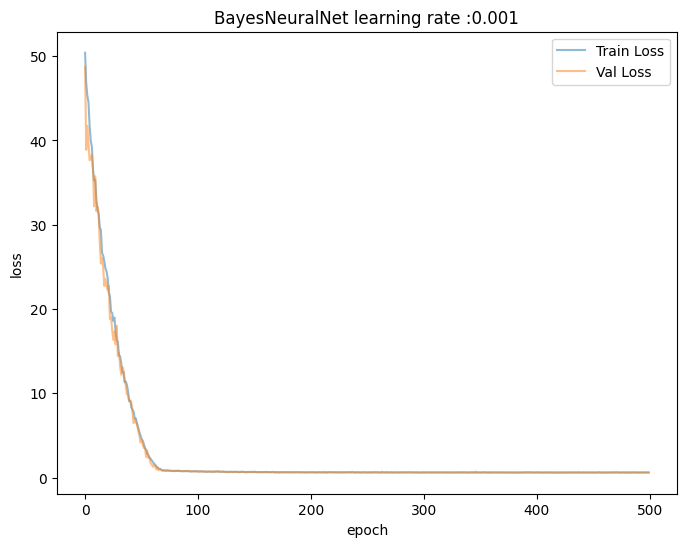

In [80]:
plot_training(history=history,learning_rate=learning_rate)

Predictions mean: 6.15, Predictions  std: 0.13, Actual: 7
Predictions mean: 6.54, Predictions  std: 0.06, Actual: 6
Predictions mean: 5.53, Predictions  std: 0.18, Actual: 6
Predictions mean: 6.05, Predictions  std: 0.12, Actual: 6
Predictions mean: 6.49, Predictions  std: 0.06, Actual: 6
Predictions mean: 6.27, Predictions  std: 0.09, Actual: 7
Predictions mean: 6.25, Predictions  std: 0.11, Actual: 5
Predictions mean: 5.89, Predictions  std: 0.11, Actual: 7
Predictions mean: 6.35, Predictions  std: 0.09, Actual: 6
Predictions mean: 6.27, Predictions  std: 0.1, Actual: 5


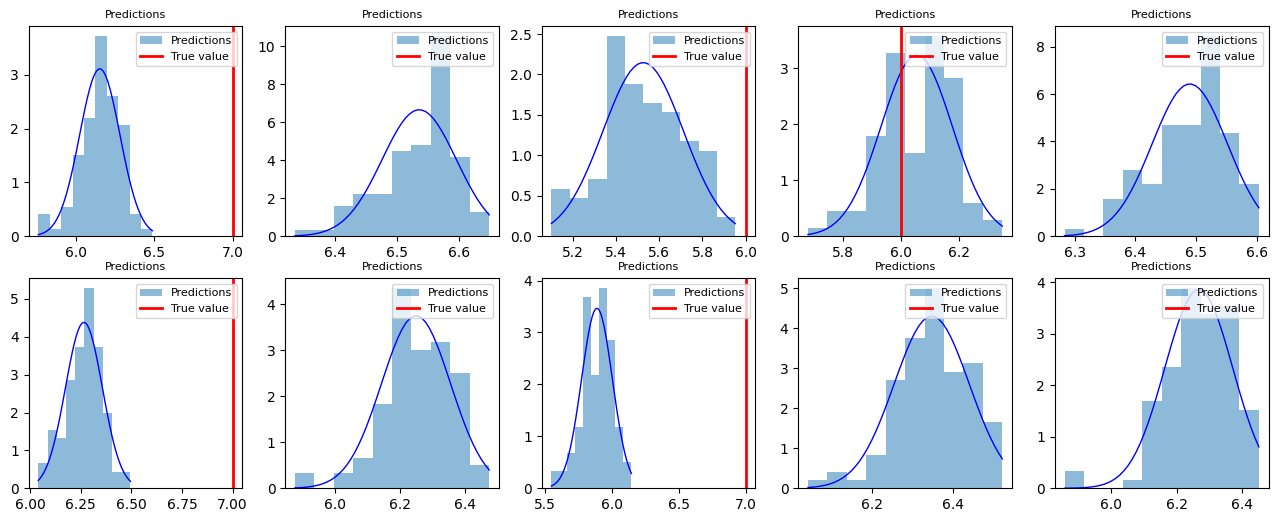

In [81]:
predictions=compute_predictions(
    model=bayes_nn_model_full,
    input=examples,
    )

display_predictions(
    predictions=predictions,
    target_values=targets,
    figsize=(16,6))

### Train Probabilistic Neural Network 

In [82]:
num_epochs = 1000

# build
prob_bnn_model = probabilistic_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=train_size)

# train
history = run_experiment(
    model=prob_bnn_model, 
    loss=negative_loglikelihood, 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/1000


TypeError: in user code:

    File "/home/codespace/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_1281/809465166.py", line 114, in negative_loglikelihood  *
        return -estimated_distribution.log_prob(targets)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1287, in log_prob  **
        return self._call_log_prob(value, name, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1269, in _call_log_prob
        return self._log_prob(value, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/layers/internal/distribution_tensor_coercible.py", line 114, in _log_prob
        return self.tensor_distribution._log_prob(value, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/distributions/independent.py", line 289, in _log_prob
        self._sum_fn(), self.distribution.log_prob(x, **kwargs))
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1287, in log_prob
        return self._call_log_prob(value, name, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1269, in _call_log_prob
        return self._log_prob(value, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/distributions/normal.py", line 186, in _log_prob
        x / scale, self.loc / scale)

    TypeError: `x` and `y` must have the same dtype, got tf.int32 != tf.float32.
